# MAT3300 Tutorial for Solving ODEs with Python

## Credits

- This jupyter notebook is written by **Weilin Cai**. It serves as a tutorial for solving ODEs with Python. 

- For the numerical methods, we utilize the formulations of the book: *Differential Equations. An Introduction to modern Methods and Applications, 3rd Edition by James R. Brannan, William E. Boyce*.

- For the analytical methods, we should give credits to the materials provided by SciPy official documentation and SciPy Lectures.

## Introduction

To "solve" ordinary differential equations(ODEs) with python, we would first think of utilizing the numerical method since the world in computer is discrete. Hence, we are doing simulation over, rather than solving, the ODEs. Here we first introduce some typical algorithms or existed tool-kits for "solving" ODEs with python. However, this doesn't mean it's impossible to use the symbolic systems for solving the ODEs, and we will still give you an example of solving ODEs analytically with python.

Note that we provide some exercises for you, and if you have time, please directly finish those exercises on your own copy of this jupyter notebook. we won't give standard solutions to these exercises as this would ruin the fun of challenges. If you've tried these exercises, we encourage you to discuss your results with your classmates who have also made a trial.

## Example Problem

The second order differential equation for the angle $\theta$ of a pendulum acted on by gravity with friction can be written:
$$
\theta''(t) + b \cdot \theta'(t) + c \cdot \sin(\theta(t)) = 0
$$

where $b$ and $c$ are positive constants, and a prime ($'$) denotes a derivative.. To solve this equation, we must first convert it to a system of first order equations. By defining the angular velocity $\omega(t) = \theta'(t)$, we obtain the system:

$$
\begin{aligned}
\theta'(t) & = \omega(t) \\
\omega'(t) & = -b \cdot \omega(t) - c \cdot \sin(\theta(t))
\end{aligned}
$$

Denotes that $y = [\theta, \omega]^T$, please implement this system in Python and solve it.

The updating process of ODEs for pendulum is defined as `pend(_, y, b, c)` as below, where `_` is a substitution for `t`, as `t` is part of the symbols of this system, while actually it doesn't influence the updated result. The parameters `b` and `c` are constant that need to be set.

In [1]:
import numpy as np

def pend(_, y, b=0.25, c=5.0):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t0 = 0
t_target = 10

For convenience of implementing our solver, we define some auxillary types and classes below.

In [2]:
from typing import Iterable, Callable, Tuple
from dataclasses import dataclass

Vec = Iterable[float]
Mat = Iterable[Iterable[float]]
ODFunc = Callable[..., Vec]
TSpan = Tuple[float, float]

@dataclass
class ODEResult:
    t: Vec
    y: Mat

We also define visualizers for our results.

In [3]:
import matplotlib.pyplot as plt

def draw_theta_and_omega_over_t(t: Vec, y_theta: Vec, y_omega: Vec, title: str = ''):
    plt.plot(t, y_theta, 'b', label=r'$\theta(t)$')
    plt.plot(t, y_omega, 'g', label=r'$\omega(t)$')
    plt.legend(loc='best')
    plt.xlabel('time(t)')
    plt.ylabel(r'$\theta(t)$ or $\omega(t)$')
    plt.title(title)
    plt.grid()
    plt.show()

def draw_theta_over_omega(theta: Vec, omega: Vec, title: str=''):
    plt.plot(omega, theta, 'r')
    plt.xlabel(r'$\omega(t)$')
    plt.ylabel(r'$\theta(t)$')
    plt.title(title)
    plt.grid()
    plt.show()

## Numerical Methods

### Euler's Formula

Euler's method extend the curve of the target function along the tangent line calculated by the differential equation.
Suppose the solution of the initial value problem:

$$
\left\{
    \begin{aligned}
    \frac{dy}{dt} & = f(t,y) \\
           y(t_0) & = y_0
    \end{aligned}
\right.
$$

is denoted $y = \phi(t)$ and you have a sequence of points $t_0 < t_1 < \cdots < t_n < \cdots$. For $n = 0, 1, 2, \dots$, we have the following:

*Approximation of $y = \phi(t)$ at $t=t_{n+1}$:*

$$
y_{n+1} = y_n + f(t_n, y_n)(t_{n+1} - t_n)
$$

*Linear approximation of $\phi(t)$ on the interval $[t_n, t_{n+1}]$*:

$$
y(t) = y_n + f(t_n, y_n)(t-t_n)
$$

Special case: If a uniform step size $h$ is used, then $t_{n+1} - t_{n} = h$ for all $n$, so that we will have:

$$
y_{n+1} = y_n + hf(t_n, y_n)
$$

Now we implement the euler's method. Note that we use similar parameters to that of `scipy.integrate.odeint` and `scipy.integrate.solve_ivp`, which can do ODE integration and solve odes with initial value. We will introduce them in the following part of this tutorial. However, our `odeint_euler` is different from `scipy.integrate.odeint` as the stepsize is directly decided by `t`.

In [4]:
def odeint_euler(func: ODFunc, y0: Vec, t: Vec, args: Tuple = (), tfirst: bool = False) -> np.ndarray:
    """
    Integrate a system of ordinary differential equations.

    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::

        dy/dt = func(y, t, ...)  [or func(t, y, ...)]

    where y can be a vector.

    Note that this function is different from that of `scipy.integrate.odeint`
    as the stepsize is directly decided by `t`

    Parameters
    ----------
    func : callable(y, t, ...) or callable(t, y, ...)
        Computes the derivative of y at t.
        If the signature is ``callable(t, y, ...)``, then the argument
        `tfirst` must be set ``True``.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        A sequence of time points for which to solve for y. The initial
        value point should be the first element of this sequence.
        This sequence must be monotonically increasing or monotonically
        decreasing; repeated values are allowed.
    args : tuple, optional
        Extra arguments to pass to function.
    tfirst: bool, optional
        If True, the first two arguments of `func` must be ``t, y``
        instead of the default ``y, t``.

    Returns
    -------
    y : array, shape (len(t), len(y0))
        Array containing the value of y for each desired time in t,
        with the initial value `y0` in the first row.
    """
    
    y0 = np.array(y0)

    t = np.array(t)
    y = np.stack([y0])

    len_t = len(t)
    y_i = y[0]
    t_i = t[0]

    for i in range(1, len_t):
        f_i = np.array(func(t_i, y_i, *args)
                       if tfirst
                       else func(y_i, t_i, *args))
        y_i = y_i + f_i * (t[i] - t_i)
        y = np.concatenate([y, np.stack([y_i])], axis=0)
        t_i = t[i]

    return y


def solve_ivp_euler(fun: ODFunc, t_span: TSpan, y0: Vec, args: Tuple = (), h: float = 0.01) -> ODEResult:
    """Solve an initial value problem for a system of ODEs.

    This function numerically integrates a system of ordinary differential
    equations given an initial value::

        dy / dt = f(t, y)
        y(t0) = y0

    Parameters
    ----------
    fun : callable
        Right-hand side of the system. The calling signature is ``fun(t, y)``.
        Here `t` is a scalar, and there are two options for the ndarray `y`:
    args : tuple, optional
        Extra arguments to pass to function.
    t_span : 2-tuple of floats
        Interval of integration (t0, tf). The solver starts with t=t0 and
        integrates until it reaches t=tf.
    y0 : array_like, shape (n,)
        Initial state. For problems in the complex domain, pass `y0` with a
        complex data type (even if the initial value is purely real).
    h: step size of the iterative method.

    Returns
    -------
    Bunch object with the following fields defined:
    t : ndarray, shape (n_points,)
        Time points.
    y : ndarray, shape (n, n_points)
        Values of the solution at `t`.
    """
    t_start, t_target = t_span
    t = np.arange(t_start, t_target+h, h)
    y = odeint_euler(func=fun, y0=y0, t=t, args=args, tfirst=True)
    return ODEResult(t, y.T)

And then we visualize our integration result:

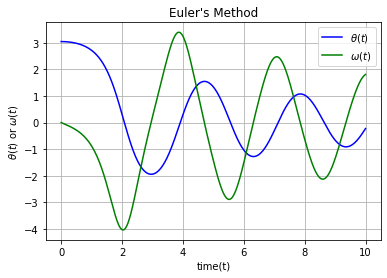

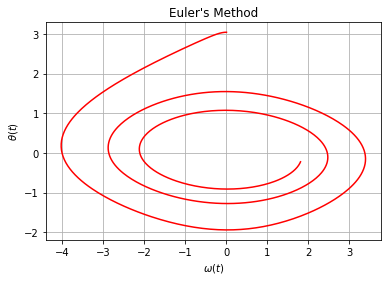

In [5]:
sol = solve_ivp_euler(pend, (t0, t_target), y0, args=(b, c), h=0.01)
t = sol.t
y = sol.y.T
draw_theta_and_omega_over_t(t, y[:, 0], y[:, 1], "Euler's Method")

draw_theta_over_omega(y[:, 0], y[:, 1], "Euler's Method")

To draw the vector field, we can utilize the `matplotlib.pyplot.quiver(X, Y, U, V)` where `X` and `Y` are the mesh grid, `U` and `V` provides the infomation of arrow direction. However, as our ODE example are second order, it's not easy to find specific derivative information when $\theta(t)$ or $\omega(t)$ with $t$ is given. You might utilize the events support of `scipy.integrate.solve_ivp` to know the derivative you want and draw such vector field, but the number of event functions would be the same as the points on the mesh grid, so it would be very time comsuming. 

For the following ODE, we give you an example of drawing the vector field:

$$
\frac{dy}{dt} = 30 - 0.15y
$$

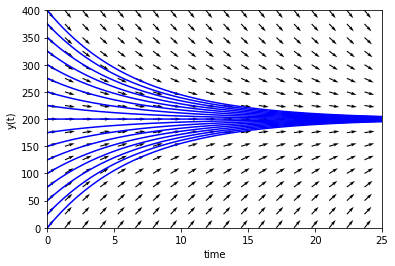

In [6]:
def first_order_ode_example(_, y):
    dydt = 30 - 0.15 * y
    return dydt

def draw_simple_vector_field():
    t0, tf, h = 0, 25, 0.01
    t = np.arange(t0, tf+h, h)
    y_min, y_max, y_step = 0, 400, 25
    y = np.arange(y_min, y_max+y_step, y_step)

    for y0 in y:
        line = odeint_euler(first_order_ode_example, y0, t, tfirst=True)
        plt.plot(t, line, 'b')

    x = np.linspace(t0, tf, 20)
    X, Y = np.meshgrid(x, y)

    U = 1
    V = first_order_ode_example(None, Y)
    N = np.sqrt(U**2 + V**2)
    U /= N
    V /= N

    plt.quiver(X, Y, U, V, angles='xy')
    plt.xlabel('time')
    plt.ylabel('y(t)')
    plt.axis([t0, tf, y_min, y_max])
    plt.show()

draw_simple_vector_field()

### Improved Euler's Formula

When you use the Euler's formula to solve ODEs, you might suffer to low accuracy if the interval, say the $h$, is not small enough. However, if $h$ is too small, the speed should be your concern. Here we introduce the improved Euler's Formula. The basic idea is to utilize information of two "extended" points.

Suppose the solution of the initial value problem

$$
\left\{
    \begin{aligned}
    \frac{dy}{dt} & = f(t,y) \\
           y(t_0) & = y_0
    \end{aligned}
\right.
$$

is denoted $y = \phi(t)$ and you have a sequence of points $t_0 < t_1 < \cdots < t_n < \cdots$. For $n = 0, 1, 2, \dots$, we have the following:

*Approximation of $y = \phi(t)$ at $t=t_{n+1}$:*

$$
y_{n+1} = y_n + \frac{h}{2}[f(t_n, y_n) + f(t_n + h, y_n + hf(t_n, y_n))]
$$

*Linear approximation of $\phi(t)$ on the interval $[t_n, t_{n+1}]$*:

$$
y(t) = y_n + f(t_n, y_n)(t-t_n)
$$

Special case: If $f(t,y)=f(t)$, i.e. $f$ is independent of $y$, we will have:

$$
y_{n+1} = y_n + \frac{h}{2}[f(t_n)+f(t_n+h)]
$$

#### Exercise 1: Influence of stepsize

In this exercise, you can try to utilize the `ipywidgets` that we've mentioned in the [last tutorial]((https://github.com/WhiskyChoy/mat3300/blob/master/tut_1/python-colab.ipynb)), and draw an interactive diagram where we can change the step size `h` and check the changes of the $\theta(t)$ and $\omega(t)$ curves.

Now we show you the implement of euler's improved method. For convenience, we just finish the `solve_ivp` part directly.

In [7]:
def solve_ivp_euler_improved(fun: ODFunc, t_span: TSpan, y0: Vec, args: Tuple = (), h: float = 0.01) -> ODEResult:
    t_start, t_target = t_span
    t = np.arange(t_start, t_target+h, h)

    y0 = np.array(y0)
    y = np.stack([y0])

    len_t = len(t)
    y_i = y[0]
    t_i = t[0]

    for i in range(1, len_t):
        f_i = np.array(fun(t_i, y_i, *args))
        f_i_next = np.array(fun(t_i + h, y_i + f_i * h, *args))
        y_i = y_i + (f_i + f_i_next) * h / 2
        y = np.concatenate([y, np.stack([y_i])], axis=0)
        t_i = t[i]
    
    return ODEResult(t, y.T)

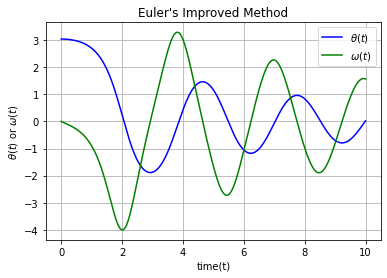

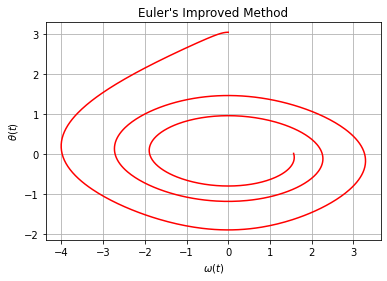

In [8]:
sol = solve_ivp_euler_improved(pend, (t0, t_target), y0, args=(b, c), h=0.01)
t = sol.t
y = sol.y.T

draw_theta_and_omega_over_t(t, y[:, 0], y[:, 1], "Euler's Improved Method")

draw_theta_over_omega(y[:, 0], y[:, 1], "Euler's Improved Method")

#### Exercise 2: Improvement of the method

In this exercise, you can set the step size `h` as 0.05 and calculate the curve of $\theta(t)$ using euler's method and improved euler's method. Draw them in the same diagram. What kind of difference can you see in the plotting results?

### Ruge-Kutta Method

The Euler's and improved Euler's method belong to what is now called the Runge-Kutta class of numerical approximation methods. Here we introduce this method:

Suppose the solution of the initial value problem

$$
\left\{
    \begin{aligned}
    \frac{dy}{dt} & = f(t,y) \\
           y(t_0) & = y_0
    \end{aligned}
\right.
$$

is denoted $y = \phi(t)$ and you have a sequence of points $t_0 < t_1 < \cdots < t_n < \cdots$. For $n = 0, 1, 2, \dots$, we have the following:

*Approximation of $y = \phi(t)$ at $t=t_{n+1}$:*

$$
y_{n+1} = y_n + \frac{h}{6}[k_{n_1} + 2k_{n_2} + 2k_{n_3} + k_{n_4}]
$$

where

$$
\left\{
    \begin{aligned}
        k_{n_1} & = f(t_n,y_n) \\
        k_{n_2} & = f(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_{n_1}) \\
        k_{n_3} & = f(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_{n_2}) \\
        k_{n_4} & = f(t_n + h, y_n + hk_{n_3})
    \end{aligned}
\right.
$$

*Linear approximation of $\phi(t)$ on the interval $[t_n, t_{n+1}]$*:

$$
y(t) = y_n + f(t_n, y_n)(t-t_n)
$$

Special case: If $f(t,y(t))=f(t)$, i.e. $f$ is independent of $y$, we will have:

$$
y_{n+1} = y_n + \frac{h}{6}[f(t_n)+4f(t_n+\frac{h}{2})+f(t_n+h)]
$$

The implementation is similar to that of euler's improved method. We shall leave it as an exercise.

#### Exercise 3: Implementation of Ruge-Kutta

In this exercise, you are suggested to imitate the codes of `solve_ivp_euler_improved` we've provided, and implement a `solve_ivp_ruge_kutta` function with same parameters as the former one. Also try to compare the plotting results and check whether there is any improvement.

### ODE Integration Using SciPy

You might have noticed that, actually we are doing integration over a system of ordinary differential equations when we are "solving" such ODEs. Actually, the `scipy` library has wrapped such functionality, and `scipy.integrate.odeint` can solve a system of ordinary differential equations using lsoda from the FORTRAN library odepack. It solves the initial value problem for stiff or non-stiff systems of first order ode that we've mentioned, i.e. $\frac{dy}{dt} = f(t,y)$, with the initial point $y(t_0) = y_0$. For details, you can check the [official documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

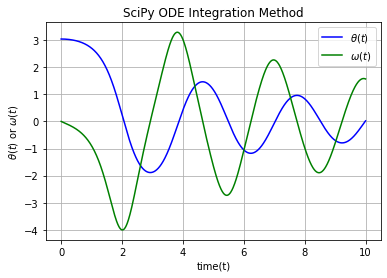

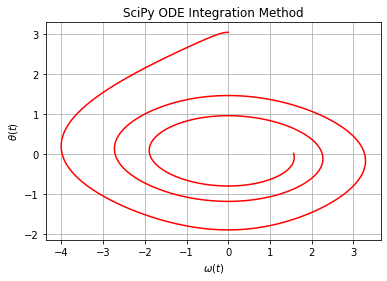

In [9]:
from scipy.integrate import odeint

h = 0.01
t = np.arange(t0, t_target+h, h)
y = odeint(pend, y0, t, args=(b, c), tfirst=True)

draw_theta_and_omega_over_t(t, y[:, 0], y[:, 1], "SciPy ODE Integration Method")

draw_theta_over_omega(y[:, 0], y[:, 1], "SciPy ODE Integration Method")

For the latest version of `scipy`, you are recommended to solve odes with initial value using ` scipy.integrate.solve_ivp`. The major differences between `odeint` and `solve_ivp` are listed below:

- You only need to provide the range (upper value and lower value) of time rather than a monotonically increasing/decreasing time sequence;
- The required order of the first two arguments of func are in the opposite order of the arguments in the system definition function used by the `scipy.integrate.odeint` and the function `scipy.integrate.solve_ivp`. To use a function with the signature func(t, y, ...), the argument `tfirst` must be set to `True` for `scipy.integrate.odeint`;
- The result is wrapped in a bunch object with time sequence, y values etc;
- Support event detection: provide the corresponding y or t value when the event function with form event(t, y(t)) = 0;
- Support dense output to compute a "continuous" solution: actually the word "continuous" here means using the time sequence as dense as you required lazily. The real continuous solution required symbolic solution, which should be introduced later.

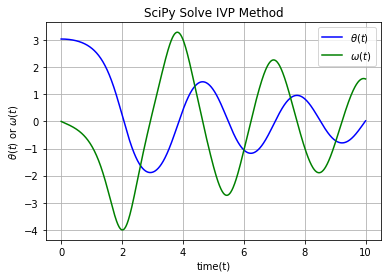

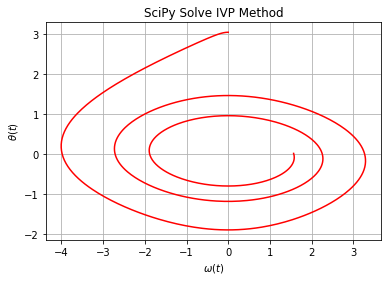

In [10]:
from scipy.integrate import solve_ivp

sol = solve_ivp_euler_improved(pend, (t0, t_target), y0, args=(b, c), h=0.01)
t = sol.t
y = sol.y.T

draw_theta_and_omega_over_t(t, y[:, 0], y[:, 1], "SciPy Solve IVP Method")

draw_theta_over_omega(y[:, 0], y[:, 1], "SciPy Solve IVP Method")

sol = solve_ivp(pend, (t0, t_target), y0, args=(b, c))

For a more general way of solving ODEs using `scipy`, you can also refer to `scipy.integrate.ode`. It's a class-oriented way and we don't show examples here. If you are interesting, you can refer to the [official document](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode). The core functionality of the methods listed above is actually the ability of getting the area under a curve, i.e. doing the integration, and this is accomplished by `scipy.integrate.quad`, you might check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) and we won't show examples either.

## Analytical Method

As is mentioned in MAT3300, only some ODEs can be solved analytically. SymPy is capable of solving such ODE, and here we will show you the example.

Rewrite the equation:

$$
\theta''(t) + b \cdot \theta'(t) + c \cdot \sin(\theta(t)) = 0
$$

into this form:

$$
f''(x) + b \cdot f'(x) + c \cdot \sin(f(x)) = 0
$$

In [21]:
from sympy import Symbol, Function, dsolve, sin

x = Symbol('x')
f = Function('f')

try:
    eq = f(x).diff(x,x) + b * f(x).diff(x) + c * sin(f(x)) # An expression, by default, is equal to 0 when considered as an equation
    dsolve(eq)
except NotImplementedError as err:
    print(err)

solve: Cannot solve 5.0*sin(f(x)) + 0.25*Derivative(f(x), x) + Derivative(f(x), (x, 2))


You can see that the it's not solvable. To simplify the problem, we set the last term as $f(x)$. Now it's solvable since it's a homogeneous linear second-order ode with constant coefficients.

In [22]:
eq = f(x).diff(x,x) + 5 * f(x).diff(x) + 6 * f(x) # An expression, by default, is equal to 0 when considered as an equation
dsolve(eq)

Eq(f(x), (C1 + C2*exp(-x))*exp(-2*x))

For more information, you might check the [official documentation of SymPy](https://docs.sympy.org/latest/modules/solvers/ode.html).